In [1]:
"""
---------------------------------------------------------------------
-- Author: Jhosimar George Arias Figueroa
---------------------------------------------------------------------

Main file to execute the model on the MNIST dataset

"""
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import argparse
import random
import numpy as np
import pickle
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from model.GMVAE import *

#########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

parser.add_argument('--expPath', type=str, default=os.path.expanduser('~/pytorchexp/mnistCNNGMVAE'),
                    help='Path for exp')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=0, help='random seed (default: 0)')

## GPU
parser.add_argument('--cuda', type=bool, default=True,
                    help='use of cuda (default: False)')
parser.add_argument('--gpuID', type=int, default=3,
                    help='set gpu id to use (default: 3)')

## Training
parser.add_argument('--training', type=bool, default=False,
                    help='Training phase?')
parser.add_argument('--epochs', type=int, default=200,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-5, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--num_classes', type=int, default=10,
                    help='number of classes (default: 10)')
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=1024, type=int,
                    help='input size (default: 784)')

## Partition parameters
parser.add_argument('--train_proportion', default=1.0, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Gumbel parameters
parser.add_argument('--init_temp', default=1.0, type=float,
                    help='Initial temperature used in gumbel-softmax (recommended 0.5-1.0, default:1.0)')
parser.add_argument('--decay_temp', default=1, type=int, 
                    help='Set 1 to decay gumbel temperature at every epoch (default: 1)')
parser.add_argument('--hard_gumbel', default=0, type=int, 
                    help='Set 1 to use the hard version of gumbel-softmax (default: 1)')
parser.add_argument('--min_temp', default=0.5, type=float, 
                    help='Minimum temperature of gumbel-softmax after annealing (default: 0.5)' )
parser.add_argument('--decay_temp_rate', default=0.013862944, type=float,
                    help='Temperature decay rate at every epoch (default: 0.013862944)')

## Loss function parameters
parser.add_argument('--w_gauss', default=1, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')
parser.add_argument('--random_search_it', type=int, default=20,
                    help='iterations of random search (default: 20)')

args, unknown = parser.parse_known_args()

def ensureDir(path):
  # Check whether the specified path exists or not
  if not os.path.exists(path):
    
    # Create a new directory because it does not exist 
    os.makedirs(path)


# Create dir
ensureDir(args.expPath)

# CUDA Semantics
if args.cuda:
    args.device = torch.device(
        "cuda:" + str(args.gpuID) if torch.cuda.is_available() else "cpu")
else:
    args.device = torch.device("cpu")

## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
  torch.cuda.manual_seed(SEED)

#########################################################
## Read Data
#########################################################
if args.dataset == "mnist":
  print("Loading mnist dataset...")
  # Download or load downloaded MNIST dataset
  train_dataset = datasets.MNIST('./mnist', train=True, download=True, transform=transforms.ToTensor())
  test_dataset = datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor())

#########################################################
## Data Partition
#########################################################
def partition_dataset(n, proportion=0.8):
  train_num = int(n * proportion)
  indices = np.random.permutation(n)
  train_indices, val_indices = indices[:train_num], indices[train_num:]
  return train_indices, val_indices

if args.train_proportion == 1.0:
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)
  val_loader = test_loader
else:
  train_indices, val_indices = partition_dataset(len(train_dataset), args.train_proportion)
  # Create data loaders for train, validation and test datasets
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
  val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)

## Calculate flatten size of each input data
args.input_size = np.prod(train_dataset[0][0].size())
print(args.input_size)
#########################################################
## Train and Test Model
#########################################################
gmvae = GMVAE(args)

if args.training:
  ## Training Phase
  history_loss, model, gumbel_temp, hard_gumbel = gmvae.train(train_loader, val_loader)
  checkpoint = {
                'model': model.inference.state_dict(),
                'hard_gumbel': hard_gumbel,
                'gumbel_temp' : gumbel_temp
            }
  torch.save(checkpoint, os.path.join(args.expPath,'inference-mlp-original.pt'))
  print('model saved...')

  ## Testing Phase
  accuracy, nmi = gmvae.test(test_loader)
  print("Testing phase...")
  print("Accuracy: %.5lf, NMI: %.5lf" % (accuracy, nmi) )
else:
  # Create model
  loaded_inference_model = gmvae.network.inference

  # load checkpoint and parameters
  loaded = torch.load(os.path.join(args.expPath,'inference-mlp-original.pt'))
  m_state_dict = loaded['model']
  hard_gumbel = loaded['hard_gumbel']
  gumbel_temp = loaded['gumbel_temp']

  # update model
  loaded_inference_model.load_state_dict(m_state_dict)
  
  features = []
  labels = []
  with torch.no_grad():
      for data, label in test_loader:
        data = data.to(args.device)

        size_int = 128
        data = F.interpolate(data, size=size_int)
        data = data.repeat(1, 3, 1, 1)  # Grayscale to RGB!
      
        # flatten data
        # data = data.view(data.size(0), -1)

        # forward call
        out_net = loaded_inference_model(data, gumbel_temp, hard_gumbel)
        
        # Feature extraction for batch
        feature_batch = out_net['gaussian'].detach().cpu().numpy()
        features.append(feature_batch)
        
        # Labels
        label_batch = label.detach().cpu().numpy()
        labels.append(label_batch)

  # Ultimate features
  features = np.vstack(features)
  labels = np.hstack(labels)
  data_to_save = {'features': features, 'labels': labels}

  with open(os.path.join(args.expPath,'features.pickle'), 'wb') as handle:
    pickle.dump(data_to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
  # Sanity check
  with open(os.path.join(args.expPath,'features.pickle'), 'rb') as handle:
    data_to_load = pickle.load(handle)


  # TSNE
  import numpy as np
  from sklearn.manifold import TSNE

  tsne_kwargs = {
        "n_components": 2,
        "n_iter": 1000,
        "n_iter_without_progress": 200,
        "random_state": 9,
    }

  tsne_model = TSNE(**tsne_kwargs)
  res = tsne_model.fit_transform(features)
      



Loading mnist dataset...
784


/data/conda_env/torfia/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


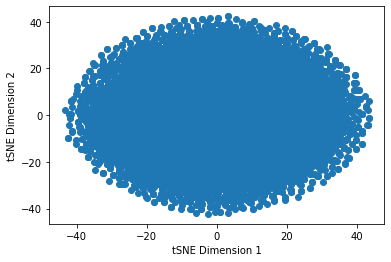

In [2]:
# PLOTTING FOR ENTIRE DATASET
plt.scatter(res[:, 0], res[:, 1], marker='o')
plt.xlabel('tSNE Dimension 1')
plt.ylabel('tSNE Dimension 2')
plt.show()
# plt.savefig(os.path.join(args.expPath,'tSNE_2components_full.png'))
plt.close()

      

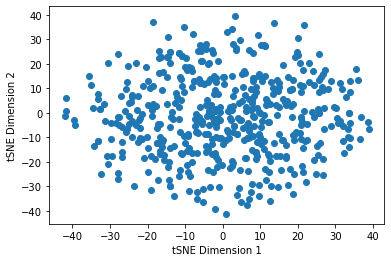

In [3]:
# RANDOMLY SAMPLE 500 POINTS FOR PLOTTING
idx = np.random.randint(res.shape[0], size=500)
plt.scatter(res[idx, 0], res[idx, 1], marker='o')
plt.xlabel('tSNE Dimension 1')
plt.ylabel('tSNE Dimension 2')
# plt.savefig(os.path.join(args.expPath,'tSNE_2components_sample500.png'))
plt.show()
plt.close()

In [ ]:
import pandas as pd
import seaborn as sns

# Picking the top 1000 points as TSNE takes a lot of time for 15K points
tsne_data = res[0:1000,:]
labels_1000 = data_to_load['labels'][0:1000][:, np.newaxis]

print(tsne_data.shape, labels_1000.shape)

# creating a new data frame which help us in ploting the result data
tsne_data = np.hstack((tsne_data, labels_1000))
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1","Dim_2","label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, "Dim_1","Dim_2").add_legend()
plt.show()